In [207]:
import numpy as np
import pandas as pd
import os
import math
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]= "true"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [20, 5] # グラフサイズ

In [208]:
## ラグ付きデータセット生成関数
def gen_dataset(dataset, lag_max):
    X, y = [], []
    for i in range(len(dataset) - lag_max):
        a = i + lag_max
        X.append(dataset[i:a, 0]) #ラグ変数
        y.append(dataset[a, 0])   #目的変数
    return np.array(X), np.array(y)

<AxesSubplot:>

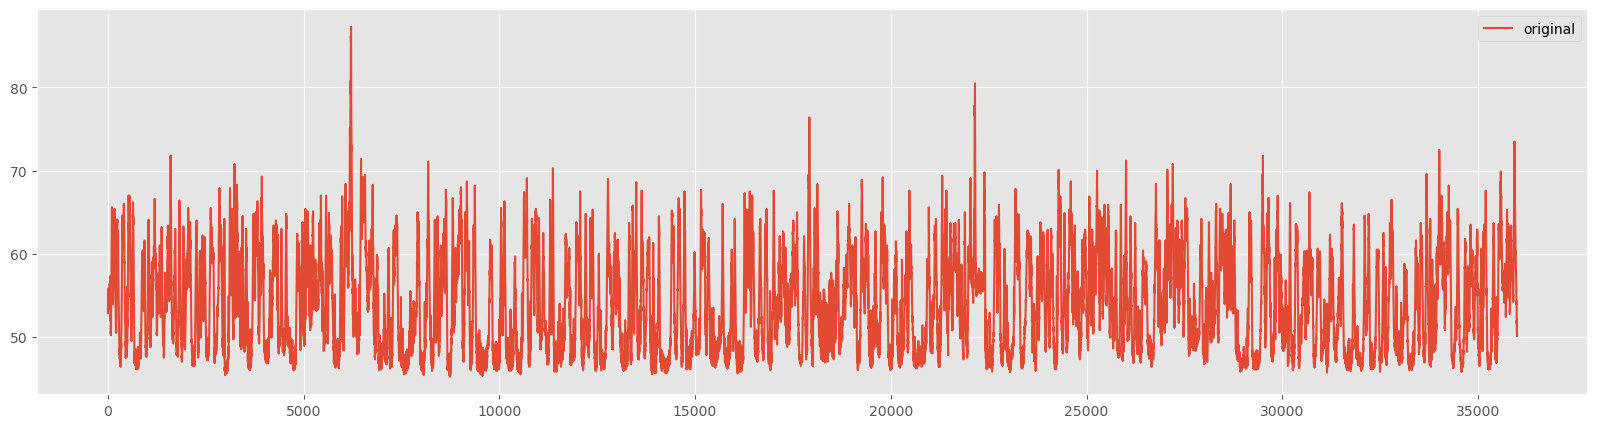

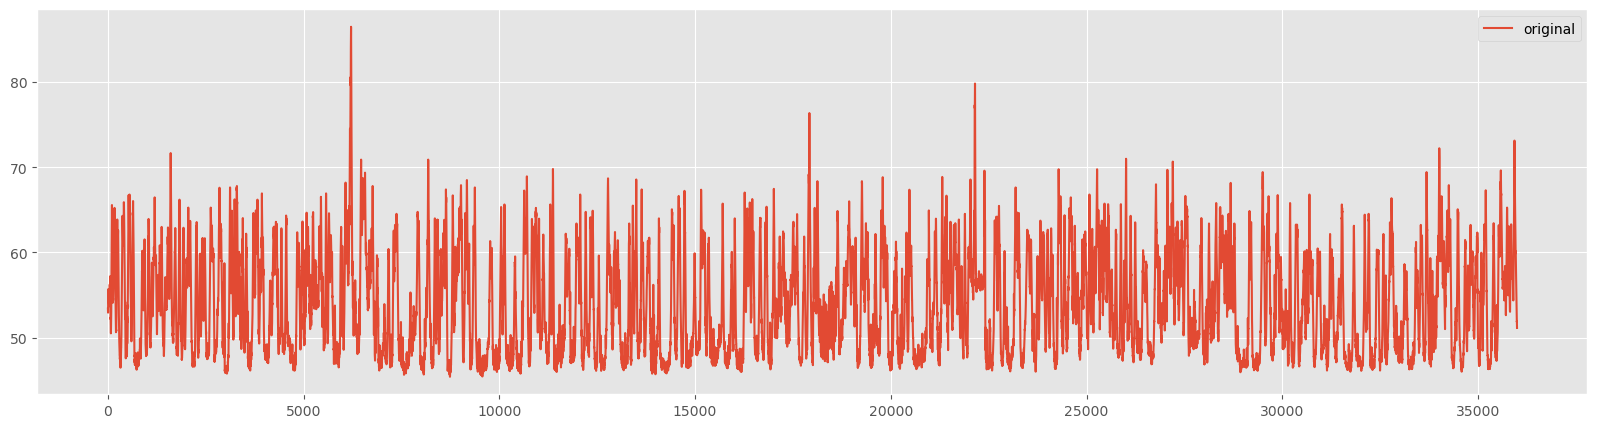

In [209]:
data = pd.read_csv( os.path.join('csv_label', 'learning_data_10.csv') )
data=data[data['day']<=0]
unit=17999
df=data.loc[:unit*2, ['original']]
label=data.loc[:unit*2, ['label']].values
df.plot()
#スムージング
df['original']=df['original'].rolling(3, min_periods=1).mean()
df.plot()

In [210]:
dataset = df['original'].values #NumPy配列へ変換
dataset = dataset.astype('float32')    #実数型へ変換
dataset

array([53.4     , 53.1     , 53.      , ..., 51.766666, 51.6     ,
       51.133335], dtype=float32)

In [211]:
dataset = np.reshape(dataset, (-1, 1)) #1次元配列を2次元配列へ変換
labelset = np.reshape(label, (-1, 1)) #1次元配列を2次元配列へ変換
print(dataset.shape, labelset.shape)

(35999, 1) (35999, 1)


In [212]:
## 分析用データセットの生成
lag_max = 10
X, y = gen_dataset(dataset, lag_max)
display(X[:8], y[:8])
print(X.shape)

array([[53.4     , 53.1     , 53.      , 52.933334, 53.2     , 53.6     ,
        54.1     , 54.8     , 55.3     , 55.633335],
       [53.1     , 53.      , 52.933334, 53.2     , 53.6     , 54.1     ,
        54.8     , 55.3     , 55.633335, 55.6     ],
       [53.      , 52.933334, 53.2     , 53.6     , 54.1     , 54.8     ,
        55.3     , 55.633335, 55.6     , 55.7     ],
       [52.933334, 53.2     , 53.6     , 54.1     , 54.8     , 55.3     ,
        55.633335, 55.6     , 55.7     , 55.7     ],
       [53.2     , 53.6     , 54.1     , 54.8     , 55.3     , 55.633335,
        55.6     , 55.7     , 55.7     , 55.5     ],
       [53.6     , 54.1     , 54.8     , 55.3     , 55.633335, 55.6     ,
        55.7     , 55.7     , 55.5     , 55.2     ],
       [54.1     , 54.8     , 55.3     , 55.633335, 55.6     , 55.7     ,
        55.7     , 55.5     , 55.2     , 54.933334],
       [54.8     , 55.3     , 55.633335, 55.6     , 55.7     , 55.7     ,
        55.5     , 55.2     , 54.9333

array([55.6     , 55.7     , 55.7     , 55.5     , 55.2     , 54.933334,
       54.9     , 54.933334], dtype=float32)

(35989, 10)


In [213]:
# データ分割
test_length = unit #テストデータの期間
X_train_0 = X[:-test_length,:] #学習データ
X_test_0 = X[-test_length:,:]  #テストデータ
y_train_0 = y[:-test_length] #学習データ
y_test_0 = y[-test_length:]  #テストデータ
y_train = y_train_0.reshape(-1,1)
y_test = y_test_0.reshape(-1,1)
display(y_train[:3])

array([[55.6],
       [55.7],
       [55.7]], dtype=float32)

In [214]:
# 正規化（0-1の範囲にスケーリング）
## 目的変数y
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train)
## 説明変数X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_0 = scaler_X.fit_transform(X_train_0)
X_test_0 = scaler_X.transform(X_test_0)

In [215]:
print('X_train_0:',X_train_0.shape) #確認
display(X_train_0[:8]) #確認
print('------------after-------------------')
# モデル構築用にデータを再構成（サンプル数、タイムステップ, 特徴量数）
X_train = np.reshape(X_train_0, (X_train_0.shape[0],X_train_0.shape[1], 1))
X_test = np.reshape(X_test_0, (X_test_0.shape[0],X_test_0.shape[1], 1))
print('X_train:',X_train.shape) #確認
display(X_train[:8]) #確認

X_train_0: (17990, 10)


array([[0.1946472 , 0.18734789, 0.18491483, 0.18329275, 0.18978095,
        0.19951332, 0.21167874, 0.22871041, 0.24087584, 0.24898624],
       [0.18734789, 0.18491483, 0.18329275, 0.18978095, 0.19951332,
        0.21167874, 0.22871041, 0.24087584, 0.24898624, 0.24817514],
       [0.18491483, 0.18329275, 0.18978095, 0.19951332, 0.21167874,
        0.22871041, 0.24087584, 0.24898624, 0.24817514, 0.2506082 ],
       [0.18329275, 0.18978095, 0.19951332, 0.21167874, 0.22871041,
        0.24087584, 0.24898624, 0.24817514, 0.2506082 , 0.2506082 ],
       [0.18978095, 0.19951332, 0.21167874, 0.22871041, 0.24087584,
        0.24898624, 0.24817514, 0.2506082 , 0.2506082 , 0.24574208],
       [0.19951332, 0.21167874, 0.22871041, 0.24087584, 0.24898624,
        0.24817514, 0.2506082 , 0.2506082 , 0.24574208, 0.23844278],
       [0.21167874, 0.22871041, 0.24087584, 0.24898624, 0.24817514,
        0.2506082 , 0.2506082 , 0.24574208, 0.23844278, 0.23195457],
       [0.22871041, 0.24087584, 0.2489862

------------after-------------------
X_train: (17990, 10, 1)


array([[[0.1946472 ],
        [0.18734789],
        [0.18491483],
        [0.18329275],
        [0.18978095],
        [0.19951332],
        [0.21167874],
        [0.22871041],
        [0.24087584],
        [0.24898624]],

       [[0.18734789],
        [0.18491483],
        [0.18329275],
        [0.18978095],
        [0.19951332],
        [0.21167874],
        [0.22871041],
        [0.24087584],
        [0.24898624],
        [0.24817514]],

       [[0.18491483],
        [0.18329275],
        [0.18978095],
        [0.19951332],
        [0.21167874],
        [0.22871041],
        [0.24087584],
        [0.24898624],
        [0.24817514],
        [0.2506082 ]],

       [[0.18329275],
        [0.18978095],
        [0.19951332],
        [0.21167874],
        [0.22871041],
        [0.24087584],
        [0.24898624],
        [0.24817514],
        [0.2506082 ],
        [0.2506082 ]],

       [[0.18978095],
        [0.19951332],
        [0.21167874],
        [0.22871041],
        [0.24087584],
  

In [216]:
# モデル定義
model = Sequential()
model.add(SimpleRNN(30,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))
# コンパイル
model.compile(loss='mean_squared_error', optimizer='adam')

In [217]:
# EaelyStoppingの設定
early_stopping =  EarlyStopping(monitor='val_loss',
                                min_delta=0.0,
                                patience=2)
# 学習の実行
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[early_stopping] ,
                    verbose=1, 
                    shuffle=False)

Epoch 1/1000
113/113 [==============================] - 1s 3ms/step - loss: 0.0092 - val_loss: 9.8996e-04
Epoch 2/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 4.4554e-04
Epoch 3/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 3.7775e-04
Epoch 4/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.4563e-04
Epoch 5/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 2.5726e-04
Epoch 6/1000
113/113 [==============================] - 0s 2ms/step - loss: 9.9434e-04 - val_loss: 2.5999e-04
Epoch 7/1000
113/113 [==============================] - 0s 2ms/step - loss: 9.0036e-04 - val_loss: 1.8981e-04
Epoch 8/1000
113/113 [==============================] - 0s 2ms/step - loss: 8.6149e-04 - val_loss: 2.1836e-04
Epoch 9/1000
113/113 [==============================] - 0s 2ms/step - loss: 7.5840e-04 - val_loss: 1.7614e-04
Epoch 10/1000
113/113 [=======

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_36 (SimpleRNN)   (None, 30)                960       
                                                                 
 dropout_21 (Dropout)        (None, 30)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


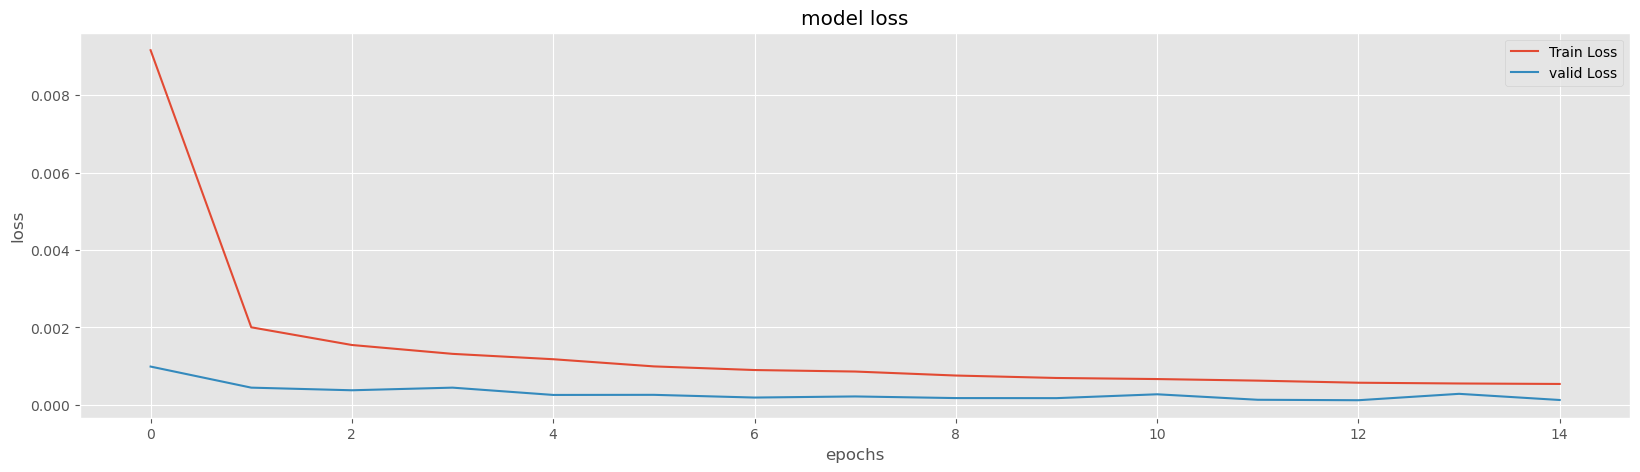

In [218]:
# 学習結果の出力
model.summary()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [219]:
# テストデータの目的変数を予測
y_test_pred = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)
# 指標出力
print('RMSE:')
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MAE:')
print(mean_absolute_error(y_test, y_test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(y_test, y_test_pred)) 

563/563 [==============================] - 0s 697us/step
RMSE:
0.55204177
MAE:
0.38488215
MAPE:
0.006986283


In [239]:
#異常度を計算
# abnorm=((y_test_pred-y_test)*100/y_test)**2
abnorm=(y_test_pred-y_test)**4
label=labelset.flatten()[-test_length:]*100
label_index=range(len(label))
num_ax=math.floor(len(y_test)/unit)

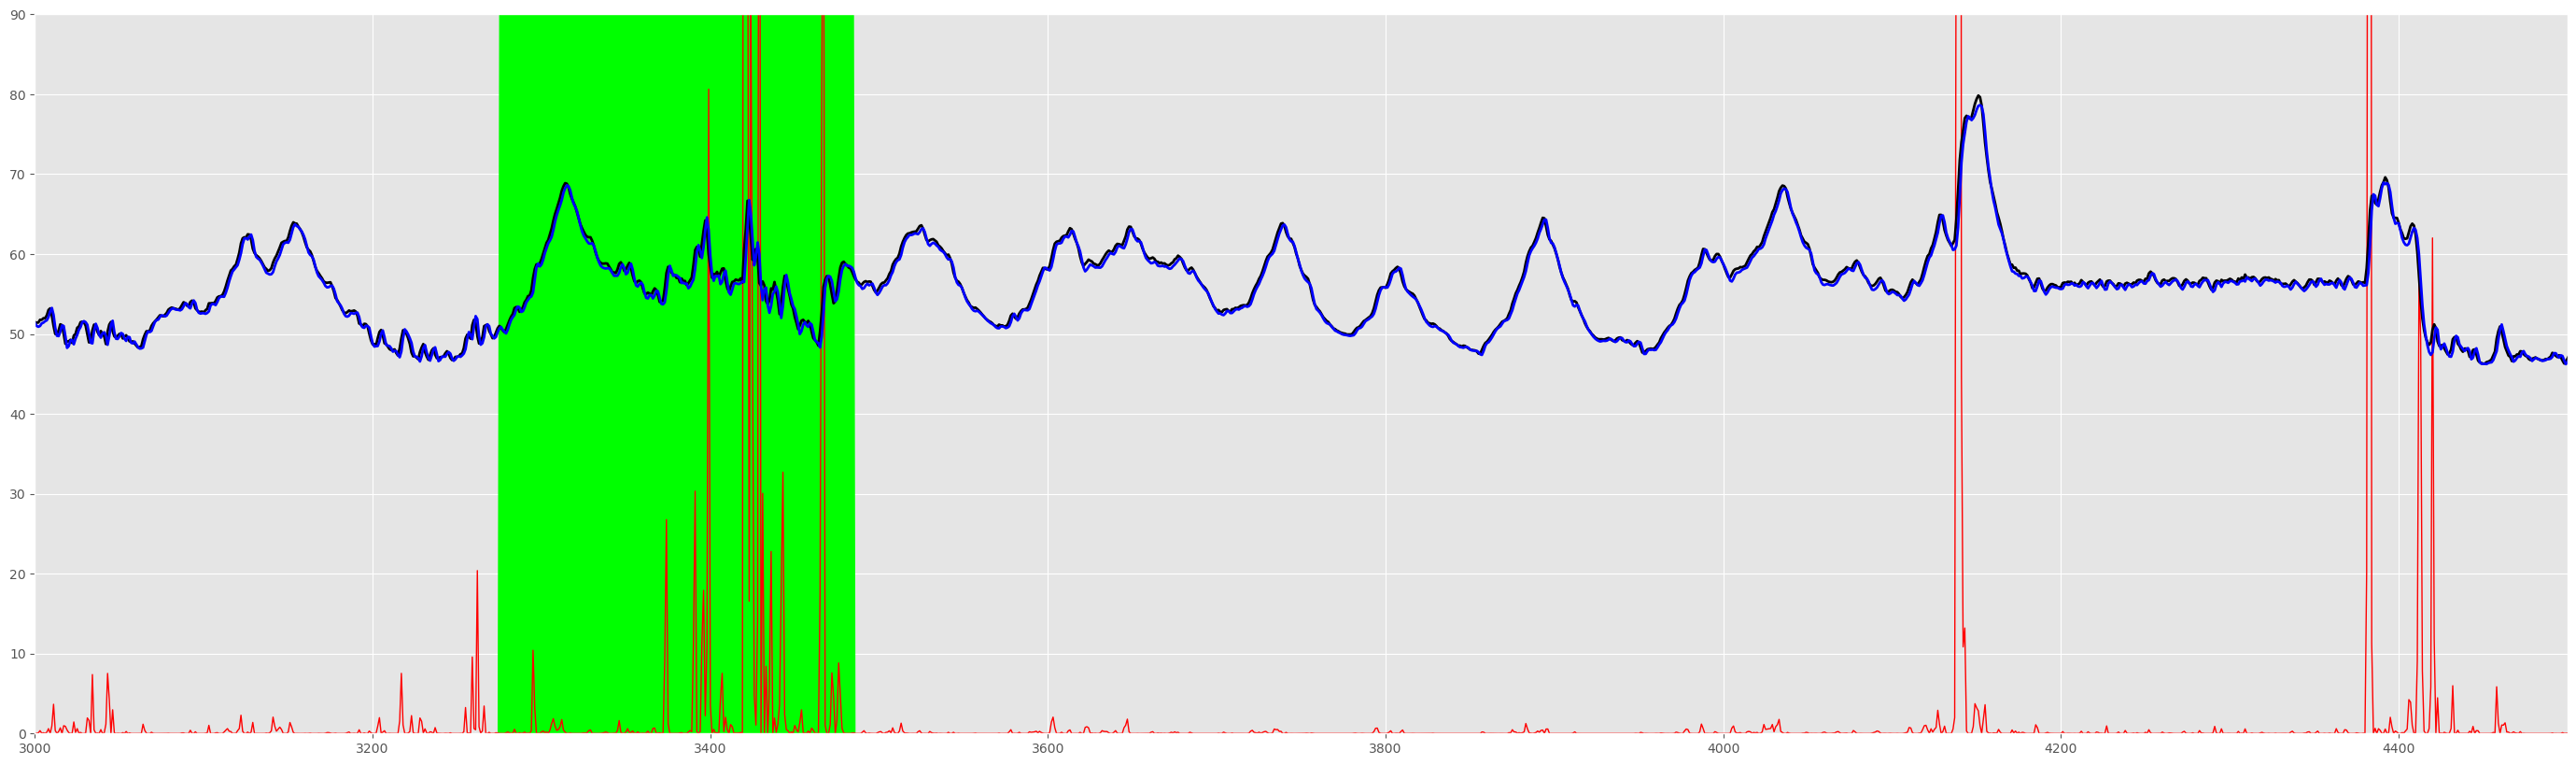

In [243]:
fig = plt.figure(figsize=(35,10))
ax1 = fig.add_subplot(111)
ax1.plot(abnorm, '-r',linewidth = 1 )
ax1.plot(y_test, '-k',linewidth = 2)
ax1.plot(y_test_pred, '-b',linewidth = 2)
ax1.fill_between(label_index, label, facecolor='lime' )
plt.xlim(3000,4500)
plt.ylim(0, 90)
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

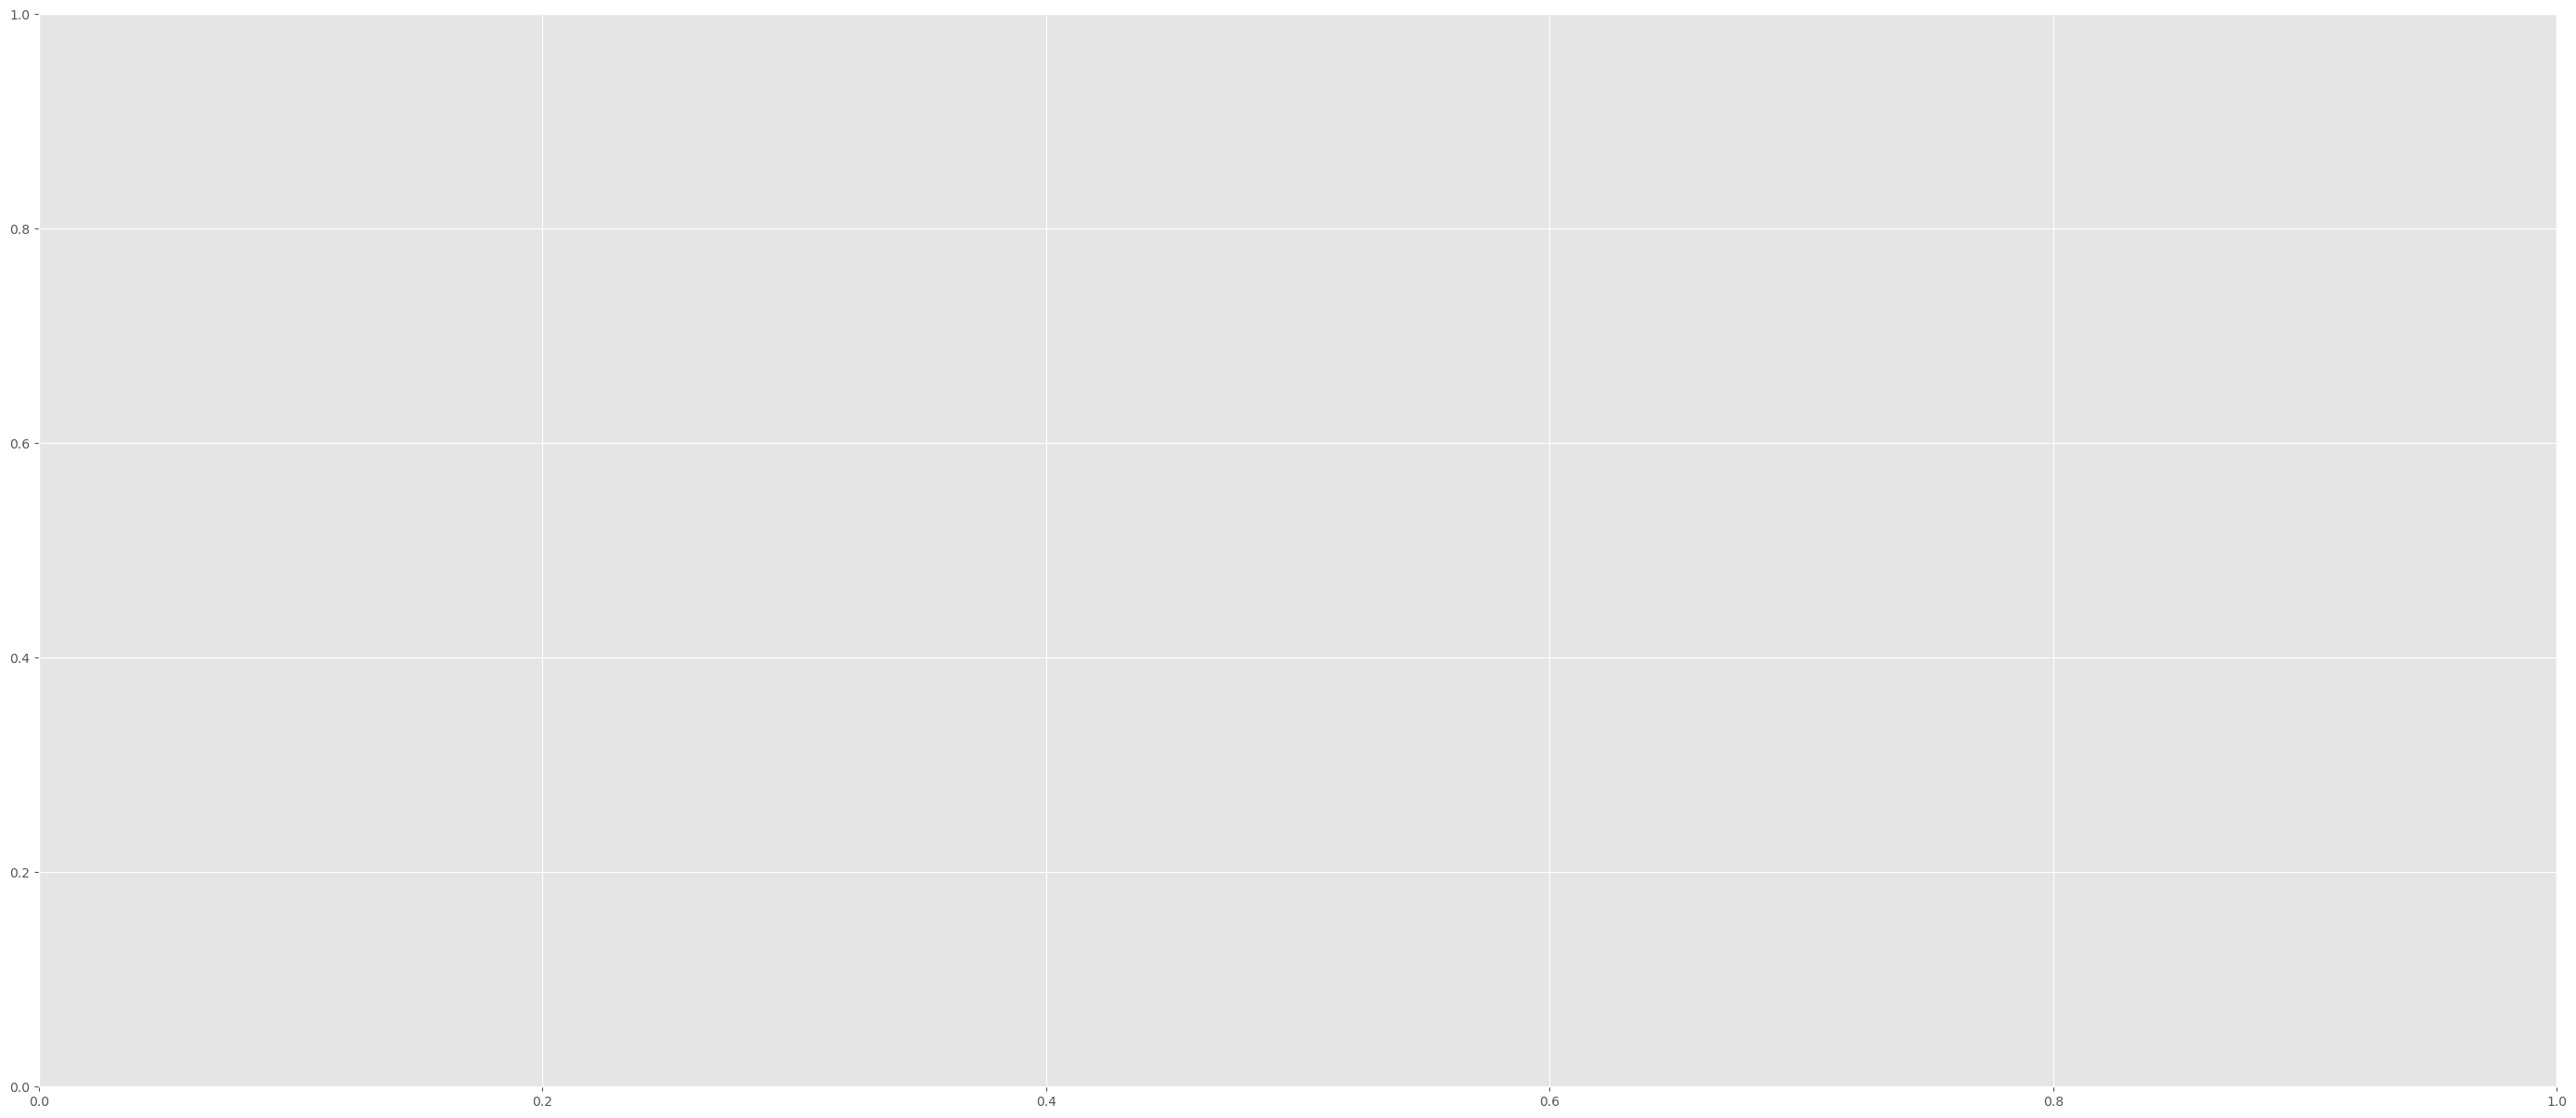

In [48]:
fig, ax=plt.subplots(num_ax, 1, figsize=(35, 15*num_ax))
for i in range(num_ax):
    ax[i].plot(abnorm, '-r',linewidth = 1 )
    ax[i].plot(y_test, '-k',linewidth = 2)
    ax[i].plot(y_test_pred, '-b',linewidth = 2)
    ax[i].fill_between(label_index, label, facecolor='lime' )
    ax[i].set_ylim(0, 90)
    ax[i].set_xlim(i*(data_unit), (data_unit)*(i+1))
plt.show()